## This is my Alzheimer's testing notebook
This is a notebook for testing the Alzheimer's dataset.
This is setup to ensure that my code works, as expected.

The reason this is not being used for the training is because the notebooks are more difficult to work with than the python files,
however the notebooks are easier to read and understand, so I shall be using them for testing and creating the graphs from the training data.

### Download the kaggle dataset and put it in ./data/

[Dataset](https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset/download?datasetVersionNumber=1)



In [20]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from pathlib import Path
import zipfile
import os
import shutil

In [2]:
# Here the data is extracted from the zip file and stored in the data folder
zip_location = './data/archive.zip'
extract_to = './data/'

with zipfile.ZipFile(zip_location, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Deleting the unnecessary files
os.remove("./data/archive.zip")
shutil.rmtree('./data/AugmentedAlzheimerDataset')

In [4]:
data_dir = Path('./data/OriginalDataset/');


"""
    Here the images are scaled to 224x224 and the images are augmented
    by rotating, shifting, shearing, zooming, flipping and vertical flipping
    This will help the model to generalize better and will help in reducing overfitting
"""
train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=360,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
) # set validation split

# Creating the training and validation data, setting the batch size to 32 as to not overload the system
train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,

    class_mode='categorical',
    subset='training')

test_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


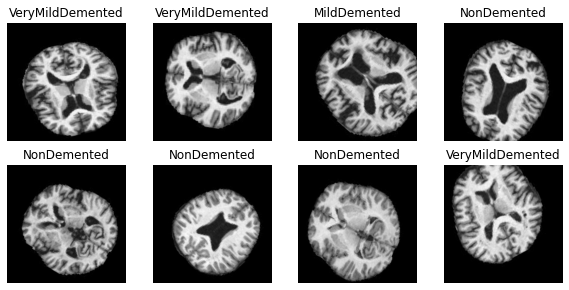

In [16]:
# Showing the first 8 images from the training data, along with their labels
# This is to check if the images are being loaded correctly and if the augmentation is working

plt.figure(figsize=(10, 10))
batch = train_ds.next()
for i in range(0, 8):
    image = batch[0][i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    labelIndex = list(batch[1][i]).index(1)
    # get the corresponding label from the train_ds.class_indices
    labels = list(train_ds.class_indices.keys())
    label = labels[labelIndex]
    plt.title(label)
    plt.axis('off')



As you can see from the image, the augmentation has been done correctly, and the images are all the same size.

In [18]:
# Here I'm using the MobileNetV2 model for testing purposes as it is a lightweight model
MobileNetV3Small = keras.applications.MobileNetV3Small(
	input_shape=(224, 224, 3),
	include_top=False, 
	weights='imagenet')


model = Sequential()

# Freezing the layers of the model so that they don't get trained (apart from the last 10)
# This should help the training to not override the feature extraction layers
for layer in MobileNetV3Small.layers[:-10]:
	layer.trainable = False

model.add(MobileNetV3Small)
# Flattening the output of the model to be able to feed it to the dense layer
model.add(Flatten())
# Adding a dense layer with 512 neurons and ReLU activation
model.add(Dense(512, activation='relu'))
# Adding a dropout layer to reduce overfitting
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
# Adding the output layer with 4 neurons and softmax activation, this is because we have 4 classes
# The softmax activation will give us the probability of the image belonging to each class
model.add(Dense(4, activation='softmax'))

# The summary of the model is shown, this is to check if the model is being built correctly
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 28224)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               14451200  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                      

In [21]:
# Compile the model, here the loss function is categorical crossentropy as we have more than 2 classes
# Thee learning rate is set to 0.0001 as to not make the model learn too fast and to not overshoot the minimum
model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.0001),
	metrics=['accuracy'],
	loss='binary_crossentropy',
)

# Here's where the model is trained
# It's training for 20 epochs with a batch size of 32
history = model.fit(
	train_ds,
	epochs=20, 
	steps_per_epoch=len(train_ds),
	validation_data=test_ds,
)


Epoch 1/20
850/850 [==============================] - 31s 32ms/step - loss: 0.3868 - accuracy: 0.5878 - val_loss: 0.3743 - val_accuracy: 0.5552
Epoch 2/20
850/850 [==============================] - 26s 31ms/step - loss: 0.3818 - accuracy: 0.5965 - val_loss: 0.3590 - val_accuracy: 0.6115
Epoch 3/20
850/850 [==============================] - 26s 31ms/step - loss: 0.3806 - accuracy: 0.5995 - val_loss: 0.3750 - val_accuracy: 0.5984
Epoch 4/20
850/850 [==============================] - 27s 31ms/step - loss: 0.3791 - accuracy: 0.6014 - val_loss: 0.3725 - val_accuracy: 0.5773
Epoch 5/20
850/850 [==============================] - 27s 32ms/step - loss: 0.3778 - accuracy: 0.6039 - val_loss: 0.3796 - val_accuracy: 0.5464
Epoch 6/20
850/850 [==============================] - 27s 31ms/step - loss: 0.3775 - accuracy: 0.6031 - val_loss: 0.3605 - val_accuracy: 0.6171
Epoch 7/20
850/850 [==============================] - 27s 32ms/step - loss: 0.3746 - accuracy: 0.6064 - val_loss: 0.3544 - val_accuracy:

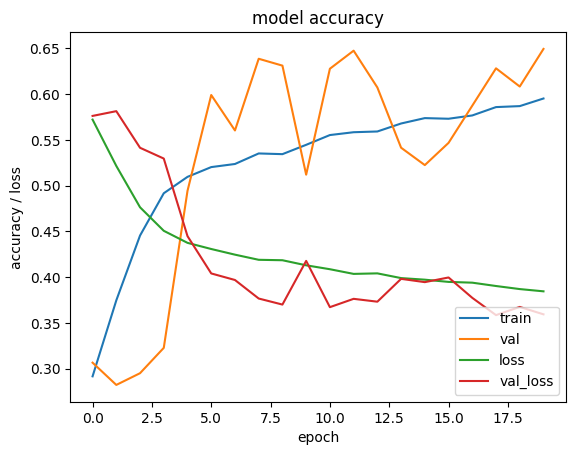

In [20]:
# Show the model history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'loss', 'val_loss'], loc='lower right')
plt.show()

In [ ]:
# This is where I'm fine tuning the model

# Unfreezing all the layers of the model
for layer in model.layers:
	layer.trainable = True

model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.00001),
	metrics=['accuracy'],
	loss='binary_crossentropy',
)

history = model.fit(
	train_ds,
	epochs=20, 
	steps_per_epoch=len(train_ds),
	validation_data=test_ds,
)

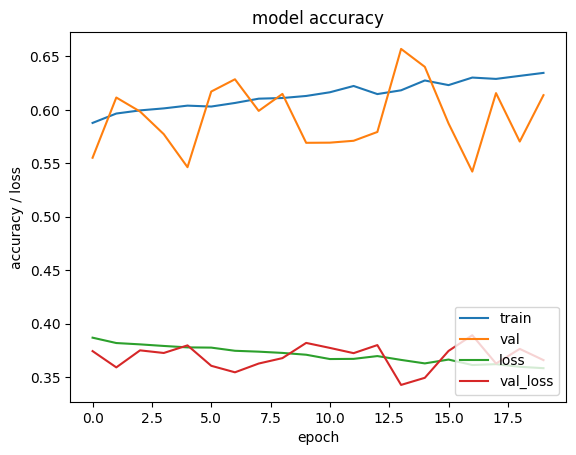

In [22]:
# Show the model history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'loss', 'val_loss'], loc='lower right')
plt.show()

In [23]:
# Make all of the model layers trainable
for layer in model.layers:
	layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(0.000001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Train the model
history = model.fit(
  train_ds,
  epochs=20,
  steps_per_epoch=len(train_ds),
  validation_data=test_ds,
)

Epoch 1/20


/home/james/.local/lib/python3.10/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


822/850 [============================>.] - ETA: 1s - loss: 20.6791 - accuracy: 0.2851

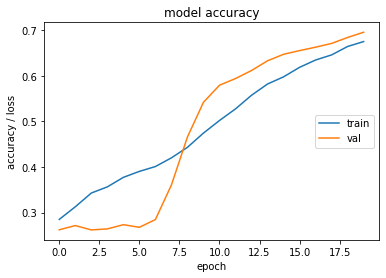

In [ ]:
# Show the model history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
"""plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])"""
plt.title('model accuracy')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center right')#, 'loss', 'val_loss'
plt.show()

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten_17 (Flatten)        (None, 47040)             0         
                                                                 
 dense_48 (Dense)            (None, 512)               24084992  
                                                                 
 dropout_31 (Dropout)        (None, 512)               0         
                                                                 
 dense_49 (Dense)            (None, 512)               262656    
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                     

In [ ]:
# Save the model
model.save('./model-v3Large')

INFO:tensorflow:Assets written to: ./model-v3Large\assets


INFO:tensorflow:Assets written to: ./model-v3Large\assets
